In [72]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

In [73]:
IMG_SIZE  = 16
 

# load data 

In [74]:
img_path = Path("data/images").resolve()
label_path = Path("data/labels").resolve()
img_path = img_path.glob("*.png")
label_path = label_path.glob("*.json")
# example y {"class": 1, "coord": [[0.46875, 0.09375, 0.171875, 0.34375]]}
X = []
Y = []
for img, label in zip(img_path, label_path):
    # resize image
    img_r = cv2.imread(str(img))
    img_r = cv2.resize(img_r, (IMG_SIZE, IMG_SIZE))
    X.append(img_r)
    
    y_merged = list(pd.read_json(label)['class'])
    y_merged.extend(pd.read_json(label)['coord'].values[0])
    Y.append(y_merged)
X = np.array(X)
Y = np.array(Y)
print(Y.shape)

(59, 5)


In [75]:
Y

array([[1.        , 0.58984375, 0.01953125, 0.234375  , 0.46875   ],
       [1.        , 0.72265625, 0.3515625 , 0.234375  , 0.46875   ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.10546875, 0.125     , 0.234375  , 0.46875   ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.19140625, 0.44140625, 0.234375  , 0.46875   ],
       [1.        , 0.2734375 , 0.46484375, 0.234375  , 0.46875   ],
       [1.        , 0.390625  , 0.30078125, 0.234375  , 0.46875   ],
       [1.        , 0.546875  , 0.171875  , 0.234375  , 0.46875   ],
       [1.        , 0.43359375, 0.08984375, 0.234375  , 0.46875   ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.515625  , 0.

*we added black players just to make task harder for model*

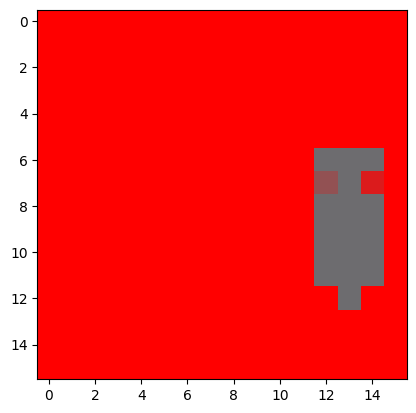

In [76]:
plt.imshow(X[1])

## prepare data
1. resizes images to SIZExSIZE
2. normalizes images to [0,1]

In [77]:
X = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X] 
# greyscale
X = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]
X = np.array(X)
# normalize
X = X / 255.0


print(X.shape, Y.shape)

(59, 16, 16) (59, 5)


[0.359375 0.140625 0.234375 0.46875 ]
[0.36328125 0.01953125 0.234375   0.46875   ]
[0. 0. 0. 0.]
[0.53515625 0.29296875 0.234375   0.46875   ]
[0.18359375 0.40234375 0.234375   0.46875   ]
[0.359375 0.140625 0.234375 0.46875 ]


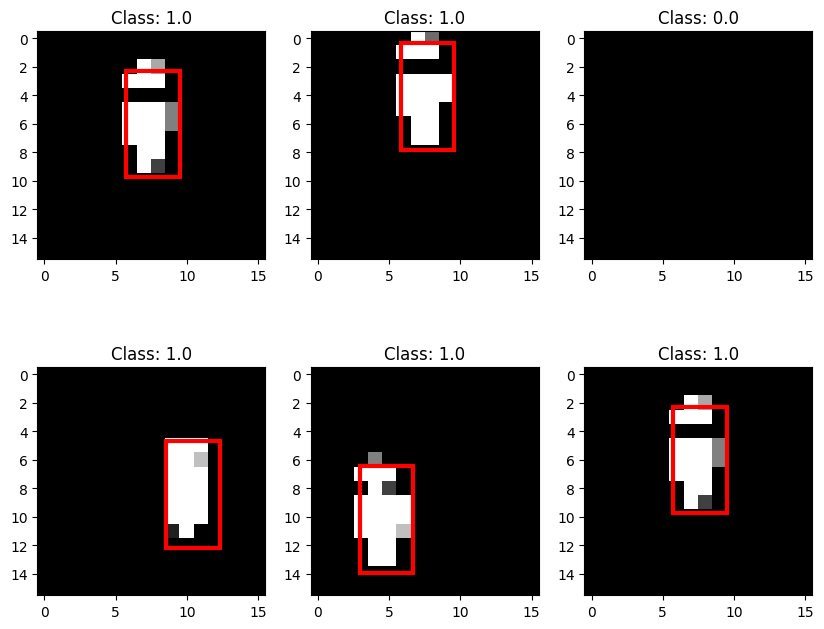

In [78]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
images = np.random.choice(X.shape[0], 6)

for i in range(2):
    for j in range(3):
        rect = Y[images[i * 3 + j]][1:]
        label = Y[images[i * 3 + j]][0]
        print(rect)
        x, y, w, h = rect
        ax[i, j].add_patch(
            plt.Rectangle(
                (x * IMG_SIZE, y * IMG_SIZE),
                w * IMG_SIZE,
                h * IMG_SIZE,
                fill=False,
                edgecolor="red",
                lw=3,
            )
        )
        ax[i,j].set_title(f"Class: {label}")
        ax[i, j].imshow(X[images[i * 3 + j]], cmap="gray")

plt.show()


In [79]:
# split data into train and test
X = X.reshape(X.shape[0], IMG_SIZE, IMG_SIZE ,1)

# Y = Y.reshape(Y.shape[0],4, 2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,  X_test.shape, y_train.shape, y_test.shape)


(47, 16, 16, 1) (12, 16, 16, 1) (47, 5) (12, 5)


In [80]:
y_train[0]

array([1.        , 0.68359375, 0.1328125 , 0.234375  , 0.46875   ])

In [81]:
path = Path("data").resolve()
np.save(path / "X_train.npy", X_train)
np.save(path / "X_test.npy", X_test)
np.save(path / "y_train.npy", y_train)
np.save(path / "y_test.npy", y_test)
